In [167]:
import numpy as np
import pandas as pd
import fipy as fp
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import re
import h5py
import lncrna_analysis_helper as lh
from scipy.optimize import fsolve
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [168]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','serif':['Computer Modern Sans Serif']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True
plt.rcParams.update({'figure.autolayout': True})

## Plots to make

1. Effect of nearby lncRNA on condensate nucleation - protein recruited to SE as a function of phi_p - for cases with and without RNA well
2. Effect of nearby lncRNA on condensate nucleation - 2D and 1D concentration profiles of RNA and protein at equilibirum for a few example situations - for cases with and without RNA well
3. Effect of distance on condensate nucleation - protein recruited to the condensate as a function of distance
4. Effect of distance on condensate nucleation - 2D and 1D concentration profiles of RNA and protein at equilibirum at different distances
5. The dynamics of protein recruitment to the enhancer locus
6. 2D and 1D plots of chemical potential of protein and RNA at different (and interesting time points). This will help us explain the dynamics
7. Cartoon: the model that arises and the implications for biology

In [169]:
def get_protein_concentration_profiles(param_list, target_directory, name_pattern, nx, dx, sigma, L_P, step_number,
                                    stats_file = 'stats.txt',
                                    spatial_variables_file='spatial_variables.hdf5', phi_p_thresh=0.22):
    """
    Function to run through directories with simulations for different values of the parameters in param_list, 
    and extracts the protein and RNA concentration profiles, and the some other propreties of the concentration profiles
    """
    
    data_dict = {}
        
    for i in range(len(param_list)):

        pattern = name_pattern.format(p=param_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:
                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file

                with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                    if step_number == -1:
                        counter = 1
                        while np.sum(sp_f['phi_p'][-counter]) == 0.0:
                            counter = counter + 1
                        phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][-counter])
                        phi_r = fp.CellVariable(mesh=mesh, value = sp_f['phi_r'][-counter])
                    else:
                        phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][step_number])
                        phi_r = fp.CellVariable(mesh=mesh, value = sp_f['phi_r'][step_number])
                        
                    indices_enhancer = ((mesh.x+0.5*L_P[i])**2 + mesh.y**2 
                                        < sigma**2)
                    indices_condensate = phi_p > phi_p_thresh
                    phi_avg = np.sum(phi_p.value*mesh.cellVolumes)/np.sum(mesh.cellVolumes)
                    fold_protein_in_SE = (np.sum(phi_p.value[indices_enhancer]*mesh.cellVolumes[indices_enhancer])
                                          /(phi_avg*np.sum(mesh.cellVolumes[indices_enhancer])))
                    condensate_area = np.sum(mesh.cellVolumes[indices_condensate])
                
                data_dict[param_list[i]] = {'phi_p': phi_p, 'phi_r': phi_r,  'fold': fold_protein_in_SE, 
                                            'condensate_area': condensate_area}
    
    return mesh, data_dict

In [170]:
# Function to get chemical potential

def get_chemical_potential(param_list, target_directory, name_pattern, nx, dx, sigma, L_P, step_number,
                                    stats_file = 'stats.txt',
                                    spatial_variables_file='spatial_variables.hdf5', phi_p_thresh=0.22):
    """
    Function to run through directories with simulations for different values of the parameters in param_list, 
    and extracts the protein and RNA chemical potentials
    """
    
    data_dict = {}
        
    for i in range(len(param_list)):

        pattern = name_pattern.format(p=param_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:
                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file

                with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                    if step_number == -1:
                        counter = 1
                        while np.sum(sp_f['phi_p'][-counter]) == 0.0:
                            counter = counter + 1
                        mu_p = fp.CellVariable(mesh=mesh, value = sp_f['mu_p'][-counter])
                        mu_r = fp.CellVariable(mesh=mesh, value = sp_f['mu_r'][-counter])
                    else:
                        mu_p = fp.CellVariable(mesh=mesh, value = sp_f['mu_p'][step_number])
                        mu_r = fp.CellVariable(mesh=mesh, value = sp_f['mu_r'][step_number])
                    
                data_dict[param_list[i]] = {'mu_p': mu_p, 'mu_r': mu_r}
    
    return mesh, data_dict

## Effect of nearby ncRNA on protein recruitment to the SE as a function of phi_p, for cases with and without the RNA well

### Plots of protein recruitment to enhancer for the three different cases vs. phi_p 

Presence of RNA increases protein recruitment to the SE. Localized RNA increases it even further

In [24]:
phi_p_list = [0.02, 0.03, 0.04, 0.06, 0.08, 0.1]
# phi_p_list = [0.02, 0.03, 0.04, 0.06, 0.08]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2$"
mesh_1, data_1 = get_protein_concentration_profiles(param_list=phi_p_list,  
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=-1, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[0.0]*len(phi_p_list))

# uniform lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"
#name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$"
mesh_2, data_2 = get_protein_concentration_profiles(param_list=phi_p_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=-1, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[0.0]*len(phi_p_list))

# localized lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"
#name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$"
mesh_3, data_3 = get_protein_concentration_profiles(param_list=phi_p_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=-1, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[4.0]*len(phi_p_list))

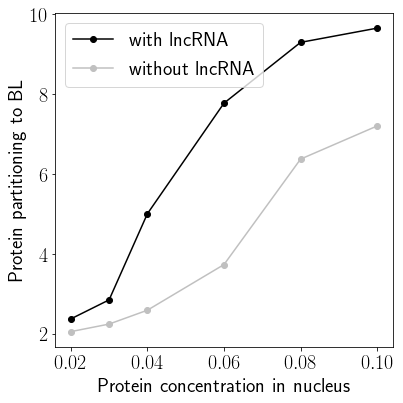

In [26]:
# Plotting the steady state protein recruitment to SE locus
L_P = 4.0
sigma = 5.0
phi_p_dense = 0.52

# fractions_1 = [data_1[x]['fold'] for x in phi_p_list]
# fractions_2 = [data_2[x]['fold'] for x in phi_p_list]
# fractions_3 = [data_3[x]['fold'] for x in phi_p_list]

indices_out_of_enhancer_1 = ((mesh_1.x)**2 + mesh_1.y**2 > sigma**2)
indices_out_of_enhancer_3 = ((mesh_3.x+0.5*L_P)**2 + mesh_3.y**2 > sigma**2)
fractions_1 = [data_1[x]['fold']*x/(np.sum(data_1[x]['phi_p'].value[indices_out_of_enhancer_1]*mesh_1.cellVolumes[indices_out_of_enhancer_1])/np.sum(mesh_1.cellVolumes[indices_out_of_enhancer_1])) for x in phi_p_list]
fractions_3 = [data_3[x]['fold']*x/(np.sum(data_3[x]['phi_p'].value[indices_out_of_enhancer_3]*mesh_3.cellVolumes[indices_out_of_enhancer_3])/np.sum(mesh_3.cellVolumes[indices_out_of_enhancer_3])) for x in phi_p_list]

# fractions_1 = [data_1[x]['fold']*x/phi_p_dense for x in phi_p_list]
# fractions_2 = [data_2[x]['fold']*x/phi_p_dense for x in phi_p_list]
# fractions_3 = [data_3[x]['fold']*x/phi_p_dense for x in phi_p_list]

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(phi_p_list, fractions_3, '-o', color='black', label='with lncRNA')
axs.plot(phi_p_list, fractions_1, '-o', color='silver', label='without lncRNA')
#axs.plot(phi_p_list, fractions_2, '-o', color='grey', label='RNA (not localized)')
axs.set_xlabel('Protein concentration in nucleus')
axs.set_ylabel('Protein partitioning to BL')
axs.legend()
plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_phi_p.svg', format='svg', dpi=600)
# plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_phi_p_phi_r_pt005.svg', format='svg', dpi=600)

In [ ]:
print([data_1[x]['fold'] for x in phi_p_list])
print([data_3[x]['fold'] for x in phi_p_list])

In [ ]:
sigma = 5.0

area_1 = [data_1[x]['condensate_area'] for x in phi_p_list]
area_2 = [data_2[x]['condensate_area'] for x in phi_p_list]
area_3 = [data_3[x]['condensate_area'] for x in phi_p_list]

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(phi_p_list, np.array(area_1)/(np.pi*sigma**2), '-o', color='silver', label='no RNA')
axs.plot(phi_p_list, np.array(area_2)/(np.pi*sigma**2), '-o', color='grey', label='RNA (not localized)')
axs.plot(phi_p_list, np.array(area_3)/(np.pi*sigma**2), '-o', color='black', label='RNA (localized)')
axs.set_xlabel('Protein volume fraction $\phi^{avg}_P$')
axs.set_ylabel('Condensate Area $A/(\pi\sigma^2)$')
axs.legend()
plt.savefig('20220223 - Figures for paper/condensate_area_vs_phi_p.svg', format='svg', dpi=600)

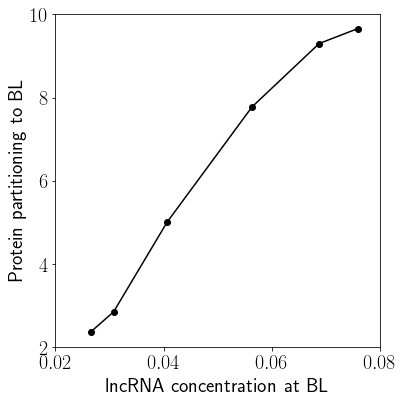

In [27]:
# Compare the amount of lncRNA protein within the SE locus
sigma = 5.0
phi_r_avg = 0.01
L_P = 4.0

# indices_enhancer_1 = (mesh_1.x**2 + mesh_1.y**2 < sigma**2)
indices_enhancer_3 = ((mesh_3.x+0.5*L_P)**2 + mesh_3.y**2 < sigma**2)
indices_out_of_enhancer_3 = ((mesh_3.x+0.5*L_P)**2 + mesh_3.y**2 > sigma**2)

fold_rna_in_SE = np.zeros(len(phi_p_list))

for i in range(len(phi_p_list)):
    phi_r = data_3[phi_p_list[i]]['phi_r']
    # phi_r_avg = np.sum(data_3[x]['phi_r'].value[indices_out_of_enhancer_3]*mesh_3.cellVolumes[indices_out_of_enhancer_3])/np.sum(mesh_3.cellVolumes[indices_out_of_enhancer_3])
    fold_rna_in_SE[i] = np.sum(phi_r.value[indices_enhancer_3]*mesh_3.cellVolumes[indices_enhancer_3])/(np.sum(mesh_3.cellVolumes[indices_enhancer_3]))

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(fold_rna_in_SE, fractions_3, '-o', color='black')
axs.xaxis.set_ticks(np.arange(0.02, 0.1, 0.02))
axs.set_xlabel('lncRNA concentration at BL')
axs.set_ylabel('Protein partitioning to BL')
plt.savefig('20220223 - Figures for paper/phi_r_SE_vs_phi_p_SE.svg', format='svg', dpi=600)



### Protein and RNA concentration profiles for phi_r = 0.001

In [28]:
phi_p_list = [0.04]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2$"
mesh_1, data_1 = get_protein_concentration_profiles(param_list=phi_p_list,  
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=-1, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[0.0]*len(phi_p_list))

# uniform lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"
# name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$"
mesh_2, data_2 = get_protein_concentration_profiles(param_list=phi_p_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=-1, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[0.0]*len(phi_p_list))

# localized lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"
# name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$"
mesh_3, data_3 = get_protein_concentration_profiles(param_list=phi_p_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=-1, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[4.0]*len(phi_p_list))

In [ ]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04, phi_r = 0.001

L_P = 4.0
delta = 0.2
sigma = 5.0
phi_p = 0.04
phi_r = 0.001

fig,axs = plt.subplots(2,1,figsize=(6,12))
indices_without_well = [(mesh_1.y < delta) * (mesh_1.y > -delta) * (mesh_1.x < 12.0) * (mesh_1.x > -12.0)]
indices_with_SE_well = [(mesh_1.y < delta) * (mesh_1.y > -delta) * (mesh_1.x < 12.0-0.5*L_P) * (mesh_1.x > -12.0-0.5*L_P)]
indices_with_rna_well = [(mesh_1.y < delta) * (mesh_1.y > -delta) * (mesh_1.x < 12.0+0.5*L_P) * (mesh_1.x > -12.0+0.5*L_P)]

axs[0].scatter((np.array(mesh_1.x[indices_without_well])-0.5*L_P)/sigma,
                np.array(data_1[phi_p]['phi_p'][indices_without_well])/phi_p, 
                label=r"no RNA", s=15, alpha=0.5, c='lightsteelblue')
axs[0].scatter((np.array(mesh_2.x[indices_without_well])-0.5*L_P)/sigma,
                np.array(data_2[phi_p]['phi_p'][indices_without_well])/phi_p, 
                label=r"RNA (not localized)", s=15, alpha=0.5, c='royalblue')
axs[0].scatter((np.array(mesh_3.x[indices_with_SE_well]))/sigma,
                np.array(data_3[phi_p]['phi_p'][indices_with_SE_well])/phi_p, 
                label=r"RNA (localized)", s=15, alpha=0.5, c='navy')

axs[0].set_ylabel(r'Protein enrichment $\phi_P(r)/\phi^{avg}_P$')
axs[0].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[0].set_xlim([-2.0,2.0])

axs[1].scatter((np.array(mesh_1.x[indices_without_well])-0.5*L_P)/sigma,
                np.array(data_1[phi_p]['phi_r'][indices_without_well])/phi_r, 
                label=r"no RNA", s=15, alpha=0.5, c='rosybrown')
axs[1].scatter((np.array(mesh_2.x[indices_without_well])-0.5*L_P)/sigma,
                np.array(data_2[phi_p]['phi_r'][indices_without_well])/phi_r, 
                label=r"RNA (not localized)", s=15, alpha=0.5, c='lightcoral')
axs[1].scatter((np.array(mesh_3.x[indices_with_rna_well]))/sigma,
                np.array(data_3[phi_p]['phi_r'][indices_with_rna_well])/phi_r, 
                label=r"RNA (localized)", s=15, alpha=0.5, c='darkred')
axs[1].set_xlabel(r'Radial position $r/\sigma$')
axs[1].set_ylabel(r'RNA enrichment $\phi_R(r)/\phi^{avg}_R$')
axs[1].set_xlim([-2.0,2.0])
axs[1].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)

plt.savefig('20220223 - Figures for paper/1d_concentration_profile_phi_p_pt04.svg', format='svg')

In [ ]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04

sigma = 5.0
phi_p = 0.04
phi_r = 0.001

min_rna_val = 0.0/phi_r
max_rna_val = 0.08/phi_r

min_protein_val = 0.0/phi_p
max_protein_val = 0.6/phi_p


# without RNA

fig,ax = plt.subplots(1,2,figsize=(13,6))

cs1 = ax[0].tricontourf(mesh_1.x/sigma, mesh_1.y/sigma, data_1[phi_p]['phi_p'].value/phi_p, 
                        levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
cs2 = ax[1].tricontourf(mesh_1.x/sigma, mesh_1.y/sigma, data_1[phi_p]['phi_r'].value/phi_r, 
                        levels=np.linspace(min_rna_val,max_rna_val,256), cmap='Reds')
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,6))
cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,6))
# cbar1.ax.tick_params(labelsize=20)
# cbar2.ax.tick_params(labelsize=20)
# # cbar1.ax.set_yticklabels(size = 10)
# # cbar2.ax.set_yticklabels(size = 10)
# ax[0].set_title(r'Protein enrichment $\phi_P/\phi^{avg}_P$',fontsize=20)
# ax[1].set_title(r'RNA enrichment $\phi_R/\phi^{avg}_R$',fontsize=20)
ax[0].set_title(r'Protein concentration $\phi_P/\phi^{avg}_P$',fontsize=20)
ax[1].set_title(r'lncRNA concentration $\phi_R/\phi^{avg}_R$',fontsize=20)

plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_phi_p_pt04_no_RNA.svg', format='svg')

# with RNA no localization

fig,ax = plt.subplots(1,2,figsize=(13,6))

cs1 = ax[0].tricontourf(mesh_2.x/sigma, mesh_2.y/sigma, data_2[phi_p]['phi_p'].value/phi_p, 
                        levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
cs2 = ax[1].tricontourf(mesh_2.x/sigma, mesh_2.y/sigma, data_2[phi_p]['phi_r'].value/phi_r, 
                        levels=np.linspace(min_rna_val,max_rna_val,256), cmap='Reds')
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,6))
cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,6))
# cbar1.ax.tick_params(labelsize=20)
# cbar2.ax.tick_params(labelsize=20)
# # cbar1.ax.set_yticklabels(size = 10)
# # cbar2.ax.set_yticklabels(size = 10)
ax[0].set_title(r'Protein enrichment $\phi_P/\phi^{avg}_P$',fontsize=20)
ax[1].set_title(r'RNA enrichment $\phi_R/\phi^{avg}_R$',fontsize=20)

plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_phi_p_pt04_with_unlocalized_RNA.svg', format='svg')

# with localized RNA

fig,ax = plt.subplots(1,2,figsize=(13,6))

cs1 = ax[0].tricontourf(mesh_3.x/sigma, mesh_3.y/sigma, data_3[phi_p]['phi_p'].value/phi_p, 
                        levels=np.linspace(min_protein_val,max_protein_val,256), cmap='Blues')
cs2 = ax[1].tricontourf(mesh_3.x/sigma, mesh_3.y/sigma, data_3[phi_p]['phi_r'].value/phi_r, 
                        levels=np.linspace(min_rna_val,max_rna_val,256), cmap='Reds')
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,6))
cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,6))
# cbar1.ax.tick_params(labelsize=20)
# cbar2.ax.tick_params(labelsize=20)
# # cbar1.ax.set_yticklabels(size = 10)
# # cbar2.ax.set_yticklabels(size = 10)
ax[0].set_title(r'Protein enrichment $\phi_P/\phi^{avg}_P$',fontsize=20)
ax[1].set_title(r'RNA enrichment $\phi_R/\phi^{avg}_R$',fontsize=20)

plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_phi_p_pt04_with_localized_RNA.svg', format='svg')


KeyboardInterrupt: 

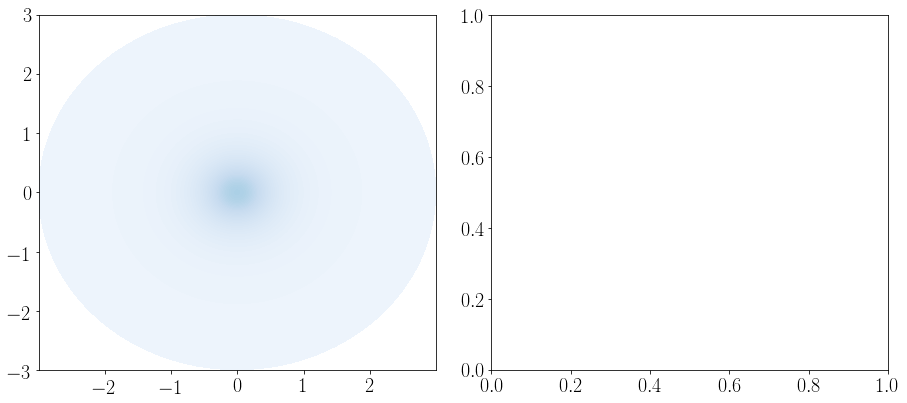

In [39]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04

sigma = 5.0
phi_p = 0.04
phi_r = 0.01

min_rna_val = 0.0
max_rna_val = 0.12

min_protein_val = 0.0
max_protein_val = 0.6


# without RNA

fig,ax = plt.subplots(1,2,figsize=(13,6))

cs1 = ax[0].tricontourf(mesh_1.x/sigma, mesh_1.y/sigma, data_1[phi_p]['phi_p'].value, 
                        levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
cs2 = ax[1].tricontourf(mesh_1.x/sigma, mesh_1.y/sigma, data_1[phi_p]['phi_r'].value, 
                        levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
ax[0].tick_params(axis='both', which='major', labelsize=50)
ax[1].tick_params(axis='both', which='major', labelsize=50)
ax[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))

cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,3))
cbar1.ax.tick_params(labelsize=50)
cbar2.ax.tick_params(labelsize=20)
# # cbar1.ax.set_yticklabels(size = 10)
# # cbar2.ax.set_yticklabels(size = 10)
ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=20)
ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=20)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
# ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
# ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)


plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_phi_p_pt04_no_RNA.svg', format='svg')

# with RNA no localization

fig,ax = plt.subplots(1,2,figsize=(13,6))

cs1 = ax[0].tricontourf(mesh_2.x/sigma, mesh_2.y/sigma, data_2[phi_p]['phi_p'].value, 
                        levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
cs2 = ax[1].tricontourf(mesh_2.x/sigma, mesh_2.y/sigma, data_2[phi_p]['phi_r'].value, 
                        levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
ax[0].tick_params(axis='both', which='major', labelsize=50)
ax[1].tick_params(axis='both', which='major', labelsize=50)
ax[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))

cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,3))
cbar1.ax.tick_params(labelsize=50)
cbar2.ax.tick_params(labelsize=50)
# # cbar1.ax.set_yticklabels(size = 10)
# # cbar2.ax.set_yticklabels(size = 10)
# ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
# ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)

plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_phi_p_pt04_with_unlocalized_RNA.svg', format='svg')

# with localized RNA

fig,ax = plt.subplots(1,2,figsize=(13,6))

cs1 = ax[0].tricontourf(mesh_3.x/sigma, mesh_3.y/sigma, data_3[phi_p]['phi_p'].value, 
                        levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
cs2 = ax[1].tricontourf(mesh_3.x/sigma, mesh_3.y/sigma, data_3[phi_p]['phi_r'].value, 
                        levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
ax[0].tick_params(axis='both', which='major', labelsize=50)
ax[1].tick_params(axis='both', which='major', labelsize=50)
ax[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
ax[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))

cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,3))
cbar1.ax.tick_params(labelsize=50)
cbar2.ax.tick_params(labelsize=50)
# # cbar1.ax.set_yticklabels(size = 10)
# # cbar2.ax.set_yticklabels(size = 10)
# ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
# ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)

plt.tight_layout()
plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_phi_p_pt04_with_localized_RNA.svg', format='svg')


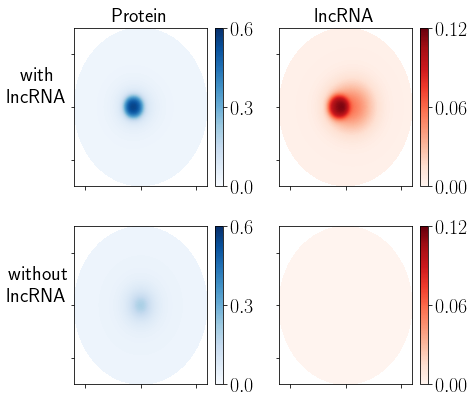

In [80]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04

sigma = 5.0
phi_p = 0.04
phi_r = 0.01

min_rna_val = 0.0
max_rna_val = 0.12

min_protein_val = 0.0
max_protein_val = 0.6


# without RNA

fig,ax = plt.subplots(2,2,figsize=(7,6))

cs1 = ax[1,0].tricontourf(mesh_1.x/sigma, mesh_1.y/sigma, data_1[phi_p]['phi_p'].value, 
                        levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
cs2 = ax[1,1].tricontourf(mesh_1.x/sigma, mesh_1.y/sigma, data_1[phi_p]['phi_r'].value, 
                        levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')

cbar1 = fig.colorbar(cs1, ax=ax[1,0], ticks=np.linspace(min_protein_val,max_protein_val,3))
cbar2 = fig.colorbar(cs2, ax=ax[1,1], ticks=np.linspace(min_rna_val,max_rna_val,3))
cbar1.ax.tick_params(labelsize=20)
cbar2.ax.tick_params(labelsize=20)
# # cbar1.ax.set_yticklabels(size = 10)
# # cbar2.ax.set_yticklabels(size = 10)
ax[1,0].axes.xaxis.set_ticklabels([])
ax[1,0].axes.yaxis.set_ticklabels([])
ax[1,1].axes.xaxis.set_ticklabels([])
ax[1,1].axes.yaxis.set_ticklabels([])
# ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
# ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)

# with localized RNA

cs1 = ax[0,0].tricontourf(mesh_3.x/sigma, mesh_3.y/sigma, data_3[phi_p]['phi_p'].value, 
                        levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
cs2 = ax[0,1].tricontourf(mesh_3.x/sigma, mesh_3.y/sigma, data_3[phi_p]['phi_r'].value, 
                        levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')

cbar1 = fig.colorbar(cs1, ax=ax[0,0], ticks=np.linspace(min_protein_val,max_protein_val,3))
cbar2 = fig.colorbar(cs2, ax=ax[0,1], ticks=np.linspace(min_rna_val,max_rna_val,3))
cbar1.ax.tick_params(labelsize=20)
cbar2.ax.tick_params(labelsize=20)
# # cbar1.ax.set_yticklabels(size = 10)
# # cbar2.ax.set_yticklabels(size = 10)
# ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
# ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)

ax[0,0].set_title('Protein',fontsize=20)
ax[0,1].set_title('lncRNA',fontsize=20)
ax[0,0].axes.xaxis.set_ticklabels([])
ax[0,0].axes.yaxis.set_ticklabels([])
ax[0,1].axes.xaxis.set_ticklabels([])
ax[0,1].axes.yaxis.set_ticklabels([])
ax[0,0].set_ylabel('with \n lncRNA', rotation=0, labelpad=30)
ax[1,0].set_ylabel('without \n lncRNA', rotation=0, labelpad=30)

plt.tight_layout()
plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_phi_p_pt04_with_localized_RNA.svg', format='svg')
plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_phi_p_pt04_with_localized_RNA.png', format='png')
plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_phi_p_pt04_with_localized_RNA.pdf', format='pdf')


## Analysis for distance effects

### Steady state concentration of protein at SE

In [97]:
# localized lncRNA
distance_list = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 15.0]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_EFFECT/'
name_pattern = ".*_L_P_{p}_.*_phi_r_00.001$"
mesh_d, data_d = get_protein_concentration_profiles(param_list=distance_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=-1, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=distance_list)

The lncRNA concentration is assumed to be proportional to the exponential of the Gaussian potential of the lncRNA, which is a reasonable approximation in the dilute regime.

$\phi_R \propto e^{e^{-|\vec{r}-\vec{r}_R|^2/\sigma^2}}$

Where $|\vec{r}-\vec{r}_R|^2 = (r \cos \theta - L_P)^2 + r^2 \sin^2 \theta = r^2 - 2 r L_P \cos \theta + L^2_P$

Since the partition ratio is proportional to lncRNA concentration at the SE, we have

Partition ratio $f(L_P) \propto \int^{r=\sigma}_{r=0} \int^{\theta=2\pi}_{\theta=0} e^{e^\frac{-r^2 + 2 r L_P \cos \theta - L^2_P}{\sigma^2}} r dr d\theta$

In [98]:
# Defining a null model

import scipy.integrate as spi

def exp_1(theta, r, L_P, sigma):
    return np.exp(10*np.exp((-r**2-L_P**2+2*r*L_P*np.cos(theta))/sigma**2))

def compute_inner_integral(r, L_P, sigma):
    f = lambda x: exp_1(x, r, L_P, sigma)
    inner_integral = spi.quad(f, 0.0, 2.0*np.pi)
    return inner_integral[0]

def compute_outer_integral(L_P, sigma):
    f = lambda x: compute_inner_integral(x, L_P, sigma) * x
    outer_integral = spi.quad(f, 0.0, sigma)
    return outer_integral[0]    

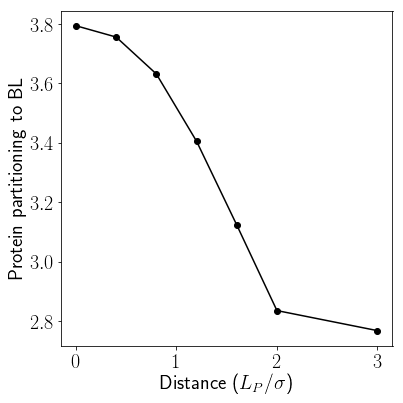

In [100]:
sigma = 5.0
phi_p = 0.04
folds = np.zeros(len(distance_list))


for i in range(len(distance_list)):

    indices_out_of_enhancer = ((mesh_d.x+0.5*distance_list[i])**2 + mesh_d.y**2 > sigma**2)
    # indices_in_enhancer = ((mesh_d.x+0.5*distance_list[i])**2 + mesh_d.y**2 < sigma**2)
    fraction_out = data_d[distance_list[i]]['fold']*phi_p/(np.sum(data_d[distance_list[i]]['phi_p'].value[indices_out_of_enhancer]*mesh_d.cellVolumes[indices_out_of_enhancer])/np.sum(mesh_d.cellVolumes[indices_out_of_enhancer]))
    # fraction_in = data_d[distance_list[i]]['fold']*phi_p/(np.sum(data_d[distance_list[i]]['phi_p'].value[indices_in_enhancer]*mesh_d.cellVolumes[indices_in_enhancer])/np.sum(mesh_d.cellVolumes[indices_in_enhancer]))
    folds[i] = fraction_out
    
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(np.array(distance_list)/sigma, folds, '-o', color='black', label='Simulations')
x = np.linspace(0.0, 15.0, 30)
# y = (np.max(folds)-np.min(folds))*np.arccos(0.5*x)/(0.5*np.pi) + np.min(folds)
y_null_fractions = [compute_outer_integral(L, sigma) for L in x]
y_null_fractions = (y_null_fractions - np.min(y_null_fractions))/(np.max(y_null_fractions)-np.min(y_null_fractions))
y_g = (np.max(folds)-np.min(folds))*np.array(y_null_fractions) + np.min(folds) 
# axs.plot(x, y, '--', label='Overlap area')
# axs.plot(x/sigma, y_g, '--r', label='Null model')
# axs.set_ylim([2.7, 3.9])
# axs.legend()
axs.set_xlabel('Distance ($L_P/\sigma$)')
axs.set_ylabel('Protein partitioning to BL')
plt.savefig('20220223 - Figures for paper/protein_recruitment_to_SE_vs_distance.svg', format='svg', dpi=600)

In [ ]:
sigma = 5.0
folds = [data_d[x]['fold'] for x in distance_list]

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(np.array(distance_list)/sigma, folds, '-o', color='purple')
axs.set_xlabel('Distance between PCG and LCL $L_P/\sigma$')
axs.set_ylabel('Total amount of loading')
plt.savefig('20220311 - Figures for APS talk/protein_recruitment_to_SE_vs_distance.svg', format='svg', dpi=600)

### Steady state condensate area

In [ ]:
sigma = 5.0
area = [data_d[x]['condensate_area'] for x in distance_list]

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(np.array(distance_list)/sigma, np.array(area)/(np.pi*sigma**2), '-o', color='black')
axs.set_xlabel('Distance between SE and RNA $L_P/\sigma$')
axs.set_ylabel('Condensate Area $A/(\pi\sigma^2)$')
plt.savefig('20220223 - Figures for paper/condensate_area_vs_distance.svg', format='svg', dpi=600)

### Steady state concentration profiles

In [ ]:
# Plotting the concentration profile of protein at different distances

delta = 0.2
sigma = 5.0
phi_p = 0.04

fig,axs = plt.subplots(1,1,figsize=(6,6))

smaller_distance_list = [0.0, 4.0, 8.0, 10.0, 15.0]

cmap = plt.get_cmap('Blues')
color_vals = np.linspace(0.3,1.0,len(smaller_distance_list))

for i in range(len(smaller_distance_list)):
    L_P = smaller_distance_list[i]
    indices_with_SE_well = [(mesh_1.y < delta) * (mesh_1.y > -delta) * (mesh_1.x < 12.0-0.5*L_P) * 
                            (mesh_1.x > -12.0-0.5*L_P)]
    axs.scatter((np.array(mesh_d.x[indices_with_SE_well])+0.5*L_P)/sigma,
                np.array(data_d[L_P]['phi_p'][indices_with_SE_well])/phi_p, label=r'$L_P/\sigma=$'+str(L_P/sigma), 
                s=15, alpha=0.5, 
                c=cmap(color_vals[i]))

axs.legend()
axs.set_xlabel('Distance from SE $r/\sigma$')
axs.set_ylabel('Protein enrichment $\phi_P(r)/\phi^{avg}_P$')
plt.savefig('20220223 - Figures for paper/protein_concentration_profile_vs_distance.svg', format='svg', dpi=600)

### Dynamics of the concentration profile

In [105]:
distance_list = [2.0, 6.0, 15.0]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_EFFECT/'
name_pattern = ".*_L_P_{p}_.*_phi_r_00.001$"

# concentration profile at t=0
mesh_d_0, data_d_0 = get_protein_concentration_profiles(param_list=distance_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=0, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=distance_list)

# concentration profile at t=6(intermediate time)
mesh_d_i, data_d_i = get_protein_concentration_profiles(param_list=distance_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=5, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=distance_list)

# concentration profile at steady state
mesh_d_ss, data_d_ss= get_protein_concentration_profiles(param_list=distance_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, step_number=-1, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=distance_list)

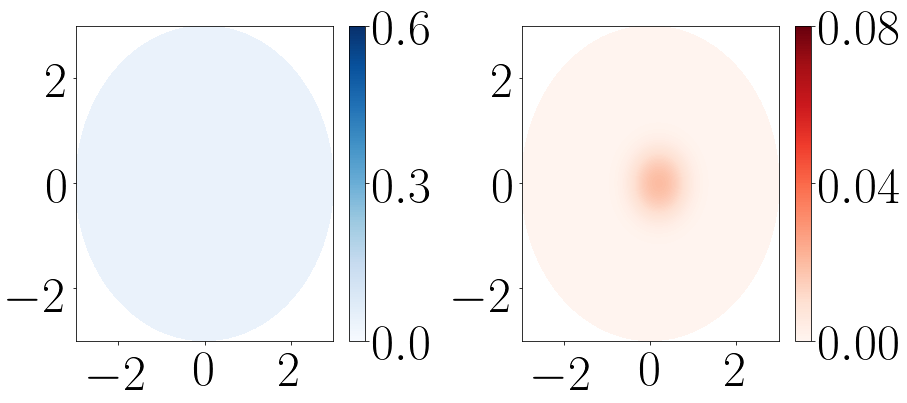

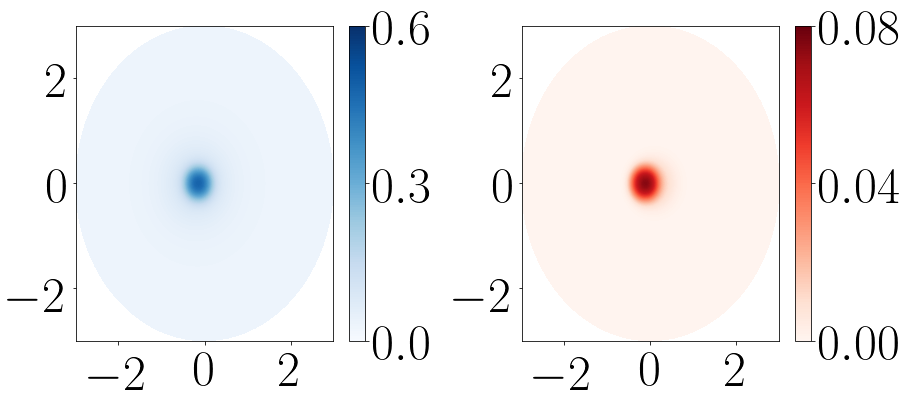

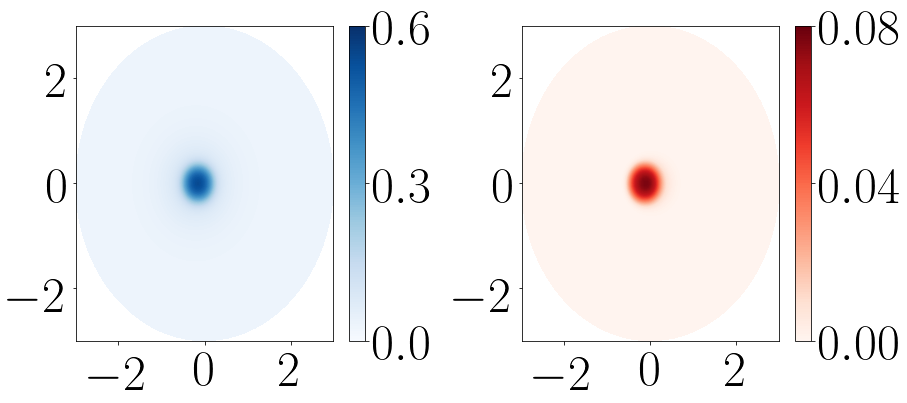

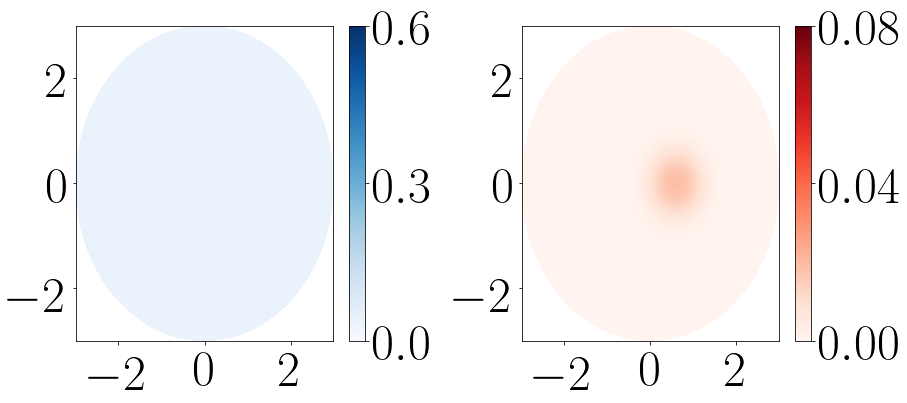

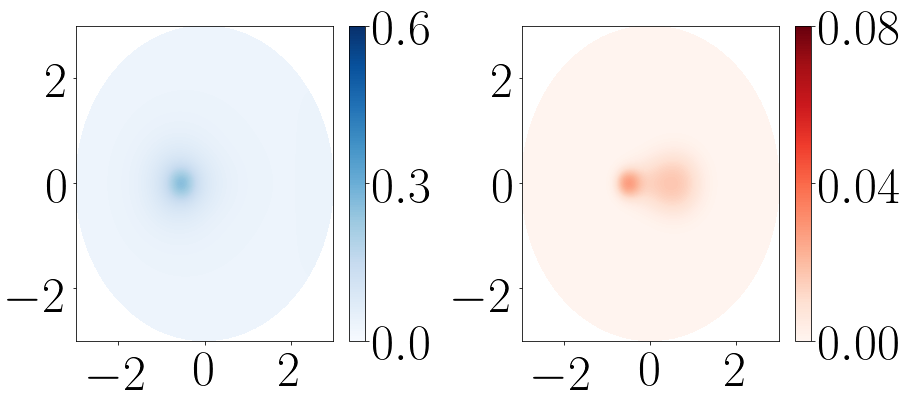

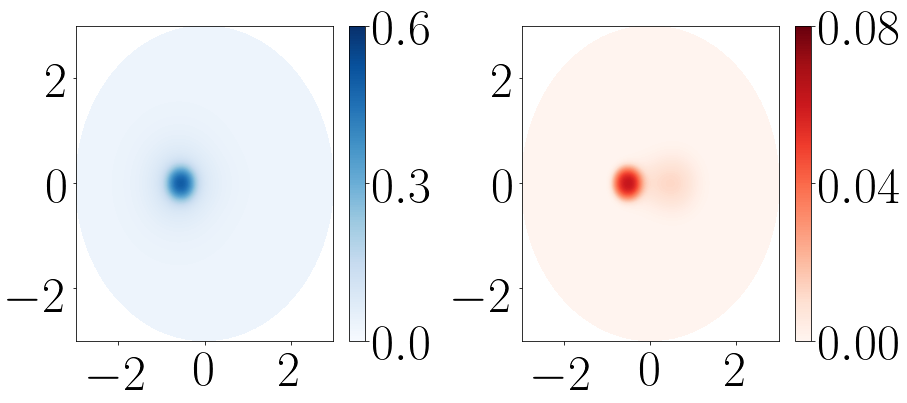

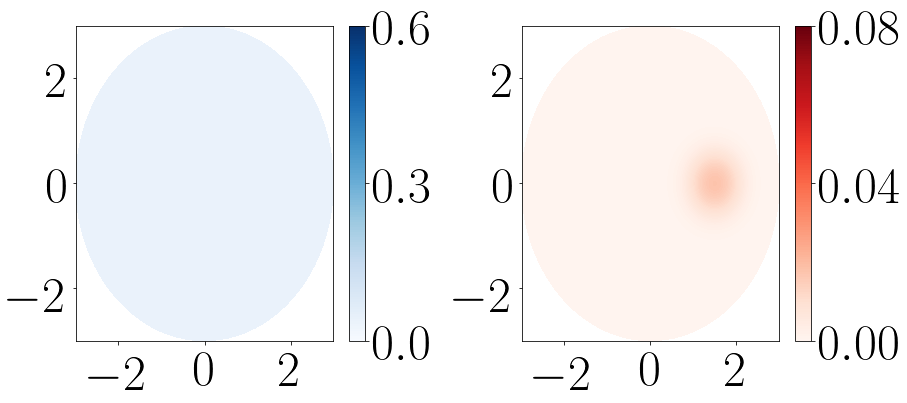

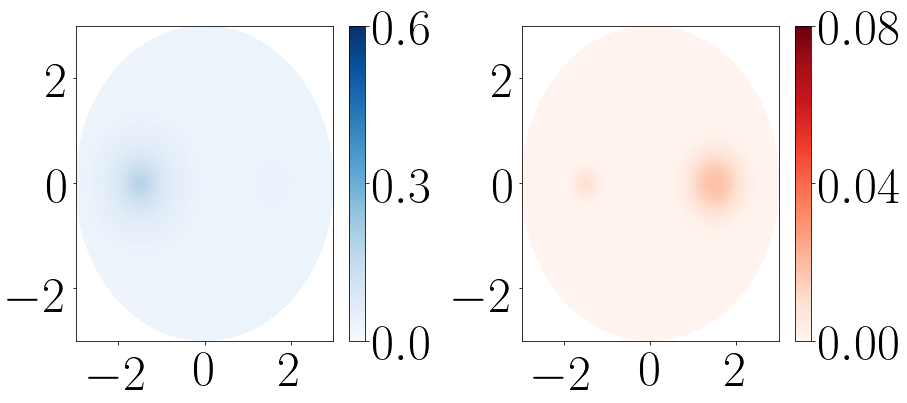

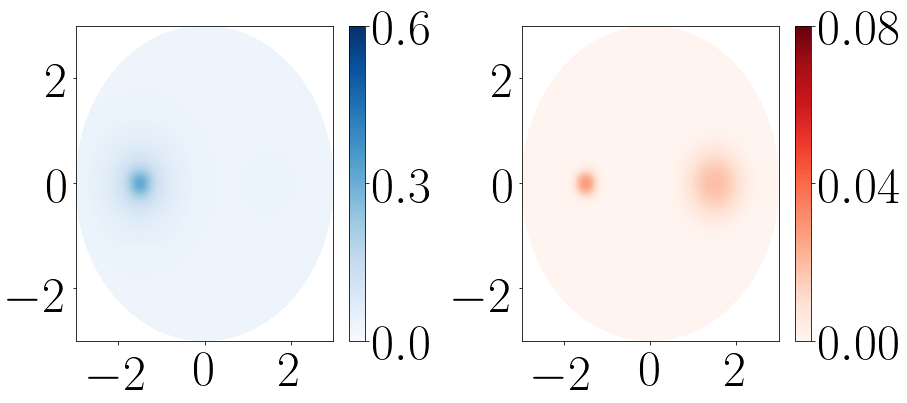

In [93]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04

sigma = 5.0
phi_p = 0.04
phi_r = 0.001

min_rna_val = 0.0
max_rna_val = 0.08

min_protein_val = 0.0
max_protein_val = 0.6


# without RNA

for i in range(len(distance_list)):

    fig,ax = plt.subplots(1,2,figsize=(13,6))

    cs1 = ax[0].tricontourf(mesh_d_0.x/sigma, mesh_d_0.y/sigma, data_d_0[distance_list[i]]['phi_p'].value, 
                            levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
    cs2 = ax[1].tricontourf(mesh_d_0.x/sigma, mesh_d_0.y/sigma, data_d_0[distance_list[i]]['phi_r'].value, 
                            levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
    ax[0].tick_params(axis='both', which='major', labelsize=50)
    ax[1].tick_params(axis='both', which='major', labelsize=50)
    ax[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))

    cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
    cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,3))
    cbar1.ax.tick_params(labelsize=50)
    cbar2.ax.tick_params(labelsize=50)
    # # cbar1.ax.set_yticklabels(size = 10)
    # # cbar2.ax.set_yticklabels(size = 10)
    # ax[0].set_title(r'Protein enrichment $\phi_P/\phi^{avg}_P$',fontsize=20)
    # ax[1].set_title(r'RNA enrichment $\phi_R/\phi^{avg}_R$',fontsize=20)
    # ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
    # ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)


    plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_L_P_{}_t_0.svg'.format(distance_list[i]), format='svg')

    # with RNA no localization

    fig,ax = plt.subplots(1,2,figsize=(13,6))

    cs1 = ax[0].tricontourf(mesh_d_i.x/sigma, mesh_d_i.y/sigma, data_d_i[distance_list[i]]['phi_p'].value, 
                            levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
    cs2 = ax[1].tricontourf(mesh_d_i.x/sigma, mesh_d_i.y/sigma, data_d_i[distance_list[i]]['phi_r'].value, 
                            levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
    ax[0].tick_params(axis='both', which='major', labelsize=50)
    ax[1].tick_params(axis='both', which='major', labelsize=50)
    ax[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))

    cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
    cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,3))
    cbar1.ax.tick_params(labelsize=50)
    cbar2.ax.tick_params(labelsize=50)
    # # cbar1.ax.set_yticklabels(size = 10)
    # # cbar2.ax.set_yticklabels(size = 10)
    # ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
    # ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)

    plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_L_P_{}_t_intermediate.svg'.format(distance_list[i]), format='svg')

    # with localized RNA

    fig,ax = plt.subplots(1,2,figsize=(13,6))

    cs1 = ax[0].tricontourf(mesh_d_ss.x/sigma, mesh_d_ss.y/sigma, data_d_ss[distance_list[i]]['phi_p'].value, 
                            levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
    cs2 = ax[1].tricontourf(mesh_d_ss.x/sigma, mesh_d_ss.y/sigma, data_d_ss[distance_list[i]]['phi_r'].value, 
                            levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
    ax[0].tick_params(axis='both', which='major', labelsize=50)
    ax[1].tick_params(axis='both', which='major', labelsize=50)
    ax[0].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[0].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[1].xaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))
    ax[1].yaxis.set_ticks(np.arange(-2.0, 2.1, 2.0))

    cbar1 = fig.colorbar(cs1, ax=ax[0], ticks=np.linspace(min_protein_val,max_protein_val,3))
    cbar2 = fig.colorbar(cs2, ax=ax[1], ticks=np.linspace(min_rna_val,max_rna_val,3))
    cbar1.ax.tick_params(labelsize=50)
    cbar2.ax.tick_params(labelsize=50)
    # # cbar1.ax.set_yticklabels(size = 10)
    # # cbar2.ax.set_yticklabels(size = 10)
    # ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
    # ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)

    plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_L_P_{}_t_ss.svg'.format(distance_list[i]), format='svg')


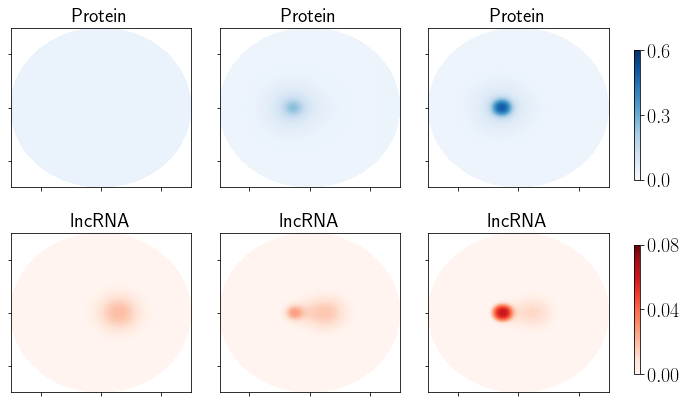

In [133]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04

sigma = 5.0
phi_p = 0.04
phi_r = 0.001

min_rna_val = 0.0
max_rna_val = 0.08

min_protein_val = 0.0
max_protein_val = 0.6

fig,ax = plt.subplots(2, 3, figsize=(9,6))
    
cs1 = ax[0,0].tricontourf(mesh_d_0.x/sigma, mesh_d_0.y/sigma, data_d_0[6.0]['phi_p'].value, 
                        levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
cs2 = ax[1,0].tricontourf(mesh_d_0.x/sigma, mesh_d_0.y/sigma, data_d_0[6.0]['phi_r'].value, 
                        levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
ax[0,0].set_title('Protein',fontsize=20)
ax[1,0].set_title('lncRNA',fontsize=20)
ax[0,0].axes.xaxis.set_ticklabels([])
ax[0,0].axes.yaxis.set_ticklabels([])
ax[1,0].axes.xaxis.set_ticklabels([])
ax[1,0].axes.yaxis.set_ticklabels([])

cs1 = ax[0,1].tricontourf(mesh_d_i.x/sigma, mesh_d_i.y/sigma, data_d_i[6.0]['phi_p'].value, 
                        levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
cs2 = ax[1,1].tricontourf(mesh_d_i.x/sigma, mesh_d_i.y/sigma, data_d_i[6.0]['phi_r'].value, 
                        levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
ax[0,1].set_title('Protein',fontsize=20)
ax[1,1].set_title('lncRNA',fontsize=20)
ax[0,1].axes.xaxis.set_ticklabels([])
ax[0,1].axes.yaxis.set_ticklabels([])
ax[1,1].axes.xaxis.set_ticklabels([])
ax[1,1].axes.yaxis.set_ticklabels([])

    
cs1 = ax[0,2].tricontourf(mesh_d_ss.x/sigma, mesh_d_ss.y/sigma, data_d_ss[6.0]['phi_p'].value, 
                        levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
cs2 = ax[1,2].tricontourf(mesh_d_ss.x/sigma, mesh_d_ss.y/sigma, data_d_ss[6.0]['phi_r'].value, 
                        levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
ax[0,2].set_title('Protein',fontsize=20)
ax[1,2].set_title('lncRNA',fontsize=20)
ax[0,2].axes.xaxis.set_ticklabels([])
ax[0,2].axes.yaxis.set_ticklabels([])
ax[1,2].axes.xaxis.set_ticklabels([])
ax[1,2].axes.yaxis.set_ticklabels([])

fig.subplots_adjust(left=0.2)
cbar_ax_1 = fig.add_axes([1, 0.55, 0.01, 0.3])
cbar_1 = fig.colorbar(cs1, cax=cbar_ax_1, pad=0.1)
cbar_ax_2 = fig.add_axes([1, 0.1, 0.01, 0.3])
cbar_2 = fig.colorbar(cs2, cax=cbar_ax_2, pad=0.1)
cbar_1.set_ticks(np.linspace(min_protein_val,max_protein_val,3))
cbar_2.set_ticks(np.linspace(min_rna_val,max_rna_val,3))
# cbar1 = fig.colorbar(cs1, ax=ax[0,2], ticks=np.linspace(min_protein_val,max_protein_val,3))
# cbar2 = fig.colorbar(cs2, ax=ax[1,2], ticks=np.linspace(min_rna_val,max_rna_val,3))
cbar1.ax.tick_params(labelsize=20)
cbar2.ax.tick_params(labelsize=20)
# fig.tight_layout()
    # # cbar1.ax.set_yticklabels(size = 10)
    # # cbar2.ax.set_yticklabels(size = 10)
    # ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
    # ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)

plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_t_dynamics.svg'.format(distance_list[i]), format='svg')
plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_t_dynamics.png'.format(distance_list[i]), format='png')
plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_t_dynamics.pdf'.format(distance_list[i]), format='pdf')


In [ ]:
# Plotting the protein and lncRNA concentration profiles for phi_p = 0.04

sigma = 5.0
phi_p = 0.04
phi_r = 0.001

min_rna_val = 0.0
max_rna_val = 0.08

min_protein_val = 0.0
max_protein_val = 0.6

fig,ax = plt.subplots(2, 3, figsize=(9,6))

for i in range(len(distance_list)):

    # with localized RNA
    
    cs1 = ax[0, i].tricontourf(mesh_d_ss.x/sigma, mesh_d_ss.y/sigma, data_d_ss[distance_list[i]]['phi_p'].value, 
                            levels=np.linspace(min_protein_val,max_protein_val,128), cmap='Blues')
    cs2 = ax[1, i].tricontourf(mesh_d_ss.x/sigma, mesh_d_ss.y/sigma, data_d_ss[distance_list[i]]['phi_r'].value, 
                            levels=np.linspace(min_rna_val,max_rna_val,128), cmap='Reds')
    ax[0, i].set_title('Protein',fontsize=20)
    ax[1, i].set_title('lncRNA',fontsize=20)
    ax[0, i].axes.xaxis.set_ticklabels([])
    ax[0, i].axes.yaxis.set_ticklabels([])
    ax[1, i].axes.xaxis.set_ticklabels([])
    ax[1, i].axes.yaxis.set_ticklabels([])

fig.subplots_adjust(left=0.2)
cbar_ax_1 = fig.add_axes([1, 0.55, 0.01, 0.3])
cbar_1 = fig.colorbar(cs1, cax=cbar_ax_1, pad=0.1)
cbar_ax_2 = fig.add_axes([1, 0.1, 0.01, 0.3])
cbar_2 = fig.colorbar(cs2, cax=cbar_ax_2, pad=0.1)
cbar_1.set_ticks(np.linspace(min_protein_val,max_protein_val,3))
cbar_2.set_ticks(np.linspace(min_rna_val,max_rna_val,3))
# cbar1 = fig.colorbar(cs1, ax=ax[0,2], ticks=np.linspace(min_protein_val,max_protein_val,3))
# cbar2 = fig.colorbar(cs2, ax=ax[1,2], ticks=np.linspace(min_rna_val,max_rna_val,3))
cbar1.ax.tick_params(labelsize=20)
cbar2.ax.tick_params(labelsize=20)
# fig.tight_layout()
    # # cbar1.ax.set_yticklabels(size = 10)
    # # cbar2.ax.set_yticklabels(size = 10)
    # ax[0].set_title(r'Protein concentration ($\phi_P$)',fontsize=50)
    # ax[1].set_title(r'lncRNA concentration ($\phi_R$)',fontsize=50)

plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_t_ss.svg'.format(distance_list[i]), format='svg')
plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_t_ss.png'.format(distance_list[i]), format='png')
plt.savefig('20220223 - Figures for paper/2d_RNA_Protein_concentration_t_ss.pdf'.format(distance_list[i]), format='pdf')


### Chemical potential profile at intermediate times where jumping happens

In [173]:
# Getting chemical potential plots to understand the distance effect

# localized lncRNA
distance_list = [2.0, 6.0, 15.0]
times_list = [0, 3, 6, 10]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_EFFECT/'
name_pattern = ".*_L_P_{p}_.*_phi_r_00.001$"

mesh_d_list = []
data_d_list = []

for i in range(len(times_list)):
    mesh_d, data_d = get_chemical_potential(param_list=distance_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=distance_list, step_number=times_list[i])
    mesh_d_list.append(mesh_d)
    data_d_list.append(data_d)

mesh_no_rna_list = []
data_no_rna_list = []

# c_max_list = [0.2]
# target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX'
# name_pattern = "phi_p0_0.04_.*_c_max_{p}$"

# for i in range(len(times_list)):
#     mesh_no_rna, data_no_rna =  get_chemical_potential(param_list=c_max_list, 
#                                                     target_directory=target_directory, 
#                                                     name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
#                                                     L_P=[0.0], step_number=times_list[i])
#     mesh_no_rna_list.append(mesh_no_rna)
#     data_no_rna_list.append(data_no_rna)

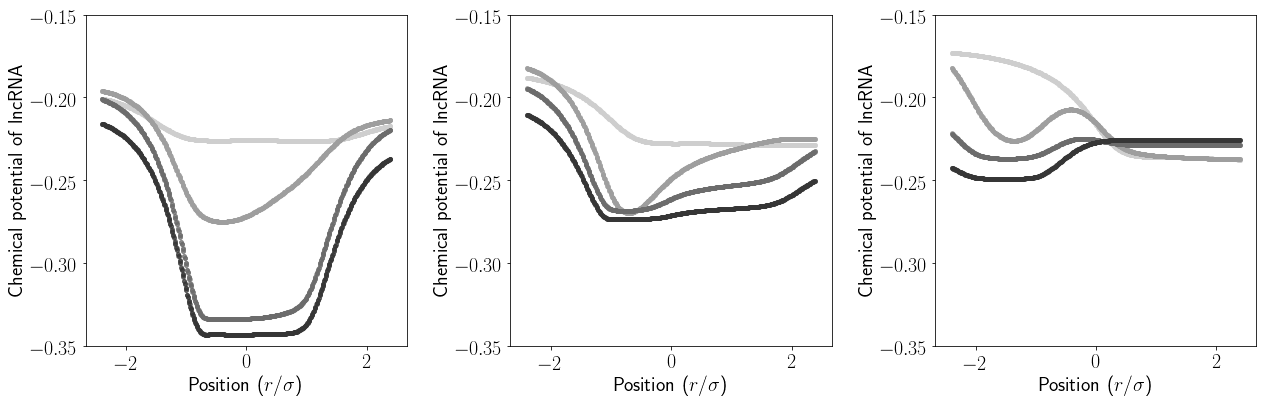

In [174]:
delta = 0.2
sigma = 5.0

cmap = plt.get_cmap('Greys')
color_vals = np.linspace(0.3,1.0,len(times_list)+1)

fig,axs = plt.subplots(1,len(distance_list),figsize=(6*len(distance_list),6))

indices_with_SE_well = [(mesh_d.y < delta) * (mesh_d.y > -delta) * (mesh_d.x < 12.0) * (mesh_d.x > -12.0)]

for i in range(len(distance_list)):
    for j in range(len(times_list)):
        axs[i].scatter((np.array(mesh_d_list[j].x[indices_with_SE_well]))/sigma,
                    np.array(data_d_list[j][distance_list[i]]['mu_r'][indices_with_SE_well]), label=r'$t=$'+str(times_list[j]), 
                    s=15, alpha=0.5, 
                    c=cmap(color_vals[j]))
    # axs[i].legend()
    axs[i].set_xlabel('Position ($r/\sigma$)')
    axs[i].set_ylabel('Chemical potential of lncRNA')  
    axs[i].set_ylim([-0.35,-0.15])
    axs[i].yaxis.set_major_locator(MaxNLocator(4))

plt.savefig('20220223 - Figures for paper/rna_chemical_potential_vs_distance.svg', format='svg')

In [ ]:
delta = 0.2
sigma = 5.0

cmap = plt.get_cmap('Blues')
color_vals = np.linspace(0.3,1.0,len(times_list)+1)

fig,axs = plt.subplots(1,len(distance_list),figsize=(7*len(distance_list),7))

indices_with_SE_well = [(mesh_d.y < delta) * (mesh_d.y > -delta) * (mesh_d.x < 12.0) * (mesh_d.x > -12.0)]

for i in range(len(distance_list)):
    for j in range(len(times_list)):
        axs[i].scatter((np.array(mesh_d_list[j].x[indices_with_SE_well])-0.5*distance_list[i])/sigma,
                    np.array(data_d_list[j][distance_list[i]]['mu_p'][indices_with_SE_well]), label=r'$t=$'+str(times_list[j]), 
                    s=15, alpha=0.5, 
                    c=cmap(color_vals[j]))
    axs[i].legend()
    axs[i].set_xlabel('Radial position relative to SE well ($r/\sigma$)')
    axs[i].set_ylabel('Chemical potential of Protein $(\mu_P)$')  

In [ ]:
delta = 0.2
sigma = 5.0

cmap = plt.get_cmap('Reds')
color_vals = np.linspace(0.3,1.0,len(distance_list)+1)

fig,axs = plt.subplots(1,1,figsize=(7,7))

for i in range(len(distance_list)):
    indices_with_SE_well = [(mesh_d.y < delta) * (mesh_d.y > -delta) * (mesh_d.x < 14.0) * (mesh_d.x > -14.0)]
    axs.scatter((np.array(mesh_d.x[indices_with_SE_well])-0.5*distance_list[i])/sigma,
                    np.array(data_d[distance_list[i]]['mu_r'][indices_with_SE_well]), label=r'$L_P/\sigma=$'+str(distance_list[i]/sigma), 
                    s=15, alpha=0.5, 
                    c=cmap(color_vals[i]))

# indices = [(mesh_no_rna.y < delta) * (mesh_no_rna.y > -delta) * (mesh_no_rna.x < 12.0) * (mesh_no_rna.x > -12.0)]
# axs.scatter((np.array(mesh_no_rna.x[indices]))/sigma,
#                         np.array(data_no_rna[0.2]['mu_r'][indices]), label='No lncRNA', 
#                         s=15, alpha=0.5, 
#                         c=cmap(color_vals[i+1]))

axs.legend()
axs.set_xlabel('Radial position relative to lncRNA well ($r/\sigma$)')
axs.set_ylabel('Chemical potential of lncRNA $(\mu_R)$')
plt.savefig('20220223 - Figures for paper/chemical_potential_profile_of_rna_at_t_0_distance_effect.svg', format='svg', dpi=600)

In [ ]:
sigma=5.0

fig,ax = plt.subplots(1,2,figsize=(13,6))

cs1 = ax[0].tricontourf(mesh_d.x/sigma, mesh_d.y/sigma, data_d[4.0]['mu_p'].value, 
                        cmap='Blues')
cs2 = ax[1].tricontourf(mesh_d.x/sigma, mesh_d.y/sigma, data_d[4.0]['mu_r'].value, 
                        cmap='Reds')
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

cbar1 = fig.colorbar(cs1, ax=ax[0])
cbar2 = fig.colorbar(cs2, ax=ax[1])
# cbar1.ax.tick_params(labelsize=20)
# cbar2.ax.tick_params(labelsize=20)
# cbar1.ax.set_yticklabels(size = 10)
# cbar2.ax.set_yticklabels(size = 10)
ax[0].set_title(r'Protein chemical potential $\mu_P$',fontsize=20)
ax[1].set_title(r'RNA chemical potential $\mu_R$',fontsize=20)

## Dynamics of protein recruitment to the SE

### Generate and store dynamical trajectories of variables in dynamical_trajectories.hdf5 files

In [46]:
def generate_dynamical_trajectories(param_list, target_directory, name_pattern, nx, dx, sigma, L_P,
                                    stats_file = 'stats.txt', dynamical_trajectory_file_name='dynamical_trajectories.hdf5',
                                    spatial_variables_file='spatial_variables.hdf5', phi_p_thresh=0.22):
    """
    Function to run through directories with simulations for different values of parameters in param_list and calculate 
    different dynamical variables as a function of time for the dynamical variables described int he below list.
    The trajectories are stored as a hdf5 file which is name "dynamical_trajectories.hdf5"
    """
    
    dynamical_variables = ['protein_in_SE', 'fold_protein_in_SE', 'rna_in_SE', 'rna_in_rna_locus', 'condensate_area',
                          'protein_out_of_SE']  
    
    for i in range(len(param_list)):

        pattern = name_pattern.format(p=param_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:
                
                # Read stats file to get times and step numbers
                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                times = df_stats['t']
                steps = df_stats['step']
                
                # Create mesh
                mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file
                
                # Creat a HDF5 file to store dynamical trajectories
                with h5py.File(os.path.join(root + '/' + dynamical_trajectory_file_name), 'w') as dt_f:
                    for dv in dynamical_variables:
                        dt_f.create_dataset(dv, shape=(len(steps),1))
                
                # Read through the spatial concentration profiles vs. time to generate trajectories for dynamical variables
                with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                    with h5py.File(os.path.join(root + '/' + dynamical_trajectory_file_name), 'a') as dt_f:
                    
                        indices_enhancer = (mesh.x+0.5*L_P[i])**2 + mesh.y**2 < sigma**2
                        indices_out_of_enhancer = (mesh.x+0.5*L_P[i])**2 + mesh.y**2 > sigma**2
                        indices_rna_locus = (mesh.x-0.5*L_P[i])**2 + mesh.y**2 < sigma**2
                        
                        for s in range(len(steps)):
                            phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][s])
                            phi_r = fp.CellVariable(mesh=mesh, value = sp_f['phi_r'][s])
                            phi_avg = np.sum(phi_p.value*mesh.cellVolumes)/np.sum(mesh.cellVolumes)
                            
                            dt_f['protein_in_SE'][s] = (np.sum(phi_p.value[indices_enhancer]
                                                                    *mesh.cellVolumes[indices_enhancer])
                                                              /(np.sum(mesh.cellVolumes[indices_enhancer])))
                            dt_f['protein_out_of_SE'][s] = (np.sum(phi_p.value[indices_out_of_enhancer]
                                                                    *mesh.cellVolumes[indices_out_of_enhancer])
                                                              /(np.sum(mesh.cellVolumes[indices_out_of_enhancer])))
                            dt_f['fold_protein_in_SE'][s] = dt_f['protein_in_SE'][s]/dt_f['protein_out_of_SE'][s]
                            dt_f['rna_in_SE'][s] = (np.sum(phi_r.value[indices_enhancer]
                                                                    *mesh.cellVolumes[indices_enhancer])
                                                              /(np.sum(mesh.cellVolumes[indices_enhancer])))
                            dt_f['rna_in_rna_locus'][s] = (np.sum(phi_r.value[indices_rna_locus]
                                                                    *mesh.cellVolumes[indices_rna_locus])
                                                              /(np.sum(mesh.cellVolumes[indices_rna_locus])))
                            condensate_indices = phi_p > phi_p_thresh
                            dt_f['condensate_area'][s] = np.sum(mesh.cellVolumes[condensate_indices])
                
                print("Succesfully wrote data to " + os.path.join(root + '/' + dynamical_trajectory_file_name) + " ...")
                            
                            

### Generate dynamical trajectories for phi_r = 0.01

In [ ]:
phi_p_list = [0.04, 0.06]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2$"
generate_dynamical_trajectories(param_list=phi_p_list,  
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[0.0]*len(phi_p_list))

# uniform lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"
generate_dynamical_trajectories(param_list=phi_p_list, 
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[0.0]*len(phi_p_list))

# localized lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"
generate_dynamical_trajectories(param_list=phi_p_list, 
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[4.0]*len(phi_p_list))

### Generate dynamical trajectories for phi_r = 0.005

In [ ]:
phi_p_list = [0.04]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2$"
generate_dynamical_trajectories(param_list=phi_p_list,  
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[0.0]*len(phi_p_list))

# uniform lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$"
generate_dynamical_trajectories(param_list=phi_p_list, 
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[0.0]*len(phi_p_list))

# localized lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$"
generate_dynamical_trajectories(param_list=phi_p_list, 
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[4.0]*len(phi_p_list))

### Generate dynamical trajectories for phi_r = 0.002

In [ ]:
phi_p_list = [0.04]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2$"
generate_dynamical_trajectories(param_list=phi_p_list,  
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[0.0]*len(phi_p_list))

# uniform lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$"
generate_dynamical_trajectories(param_list=phi_p_list, 
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[0.0]*len(phi_p_list))

# localized lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$"
generate_dynamical_trajectories(param_list=phi_p_list, 
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[4.0]*len(phi_p_list))

### Generate dynamical trajectories for phi_r = 0.001

In [ ]:
phi_p_list = [0.04]

# no lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2$"
generate_dynamical_trajectories(param_list=phi_p_list,  
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[0.0]*len(phi_p_list))

# uniform lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$"
generate_dynamical_trajectories(param_list=phi_p_list, 
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[0.0]*len(phi_p_list))

# localized lncRNA
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/'
name_pattern = "phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$"
generate_dynamical_trajectories(param_list=phi_p_list, 
                                target_directory=target_directory, 
                                name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                L_P=[4.0]*len(phi_p_list))

### Extract dynamical trajectories data and analyze them

In [47]:
def get_dynamical_trajectories(param_list, variable_name, target_directory, name_pattern, 
                                stats_file = 'stats.txt', dynamical_trajectory_file_name='dynamical_trajectories.hdf5',
                                spatial_variables_file='spatial_variables.hdf5'):
    """
    Function to run through directories with simulations for different values of parameters in param_list and get the 
    dynamical trajectory corresponding to "variable_name" in "dynamical_trajectories.hdf5"
    """
    
    trajectories = {}
    
    for i in range(len(param_list)):
        
        # Store the dynamical variable trajectories in a dictionary
        data = {}
        
        pattern = name_pattern.format(p=param_list[i])
        
        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:

                # Read stats file to get times and step numbers
                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                data['t'] = df_stats['t']
                
                # Read through the dynamical trajectories file to extract the appropriate variable
                with h5py.File(os.path.join(root + '/' + dynamical_trajectory_file_name), 'a') as dt_f:        
                    data[variable_name] = dt_f[variable_name][:,0]
        
        trajectories[param_list[i]] = data
     
    return trajectories
                

In [48]:
def get_list_of_trajectories(param_list, target_directory_list, name_pattern_list, variable_name):
    
    """
    Function to get a list of dynamical trajectories for a desired dynamical variables, each trajectory 
    derived from a folder in target_directory_list 
    """
    
    trajectories = list()
    for i in range(len(target_directory_list)):
        trajectories.append(get_dynamical_trajectories(param_list=param_list, variable_name=variable_name,
                                                       target_directory=target_directory_list[i],
                                                       name_pattern=name_pattern_list[i]))
    return trajectories

## RNA localization speeds up protein recruitment

### dynamics for phi_r = 0.01

In [ ]:
phi_p = [0.04]
diffusivity = 100.0
domain_radius = 15.0
tau_d = domain_radius**2/diffusivity

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2$",  "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"]
labels = ['no RNA', 'RNA (not localized)', 'RNA (localized)']

variable_names = ['protein_in_SE', 'fold_protein_in_SE', 'rna_in_SE', 'rna_in_rna_locus', 'condensate_area']  
ylabels = ['Average protein at SE $<\phi_P>$', 'Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           'Average RNA at SE $<\phi_R>$', 'Average RNA at RNa locus $<\phi_R>$','Condensate Area']
cmaps = ['Blues', 'Blues', 'Reds', 'Reds','Blues']
N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(5,6*N))
color_vals = np.linspace(0.3,1.0,len(target_directory_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=phi_p,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(target_directory_list)):
        axs[j].plot(trajectories[i][phi_p[0]]['t']/tau_d, trajectories[i][phi_p[0]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label=labels[i],linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    axs[j].set_xlim([-0.1,15.0])
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)

axs[j].set_xlabel('Dimensionless time $tD_P/R^2$')


### dynamics for phi_r = 0.005

In [ ]:
phi_p = [0.04]
diffusivity = 100.0
domain_radius = 15.0
tau_d = domain_radius**2/diffusivity

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2$",  "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$"]
labels = ['no RNA', 'RNA (not localized)', 'RNA (localized)']

variable_names = ['protein_in_SE', 'fold_protein_in_SE', 'rna_in_SE', 'rna_in_rna_locus','condensate_area']  
ylabels = ['Average protein at SE $<\phi_P>$', 'Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           'Average RNA at SE $<\phi_R>$', 'Average RNA at RNa locus $<\phi_R>$','Condensate Area']
cmaps = ['Blues', 'Blues', 'Reds', 'Reds','Blues']
N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(4,5*N))
color_vals = np.linspace(0.3,1.0,len(target_directory_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=phi_p,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(target_directory_list)):
        axs[j].plot(trajectories[i][phi_p[0]]['t']/tau_d, trajectories[i][phi_p[0]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label=labels[i],linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    axs[j].set_xlim([-0.1,15.0])
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)

axs[j].set_xlabel('Dimensionless time $tD_P/R^2$')


### dynamics for phi_r = 0.002

In [ ]:
phi_p = [0.04]
diffusivity = 100.0
domain_radius = 15.0
tau_d = domain_radius**2/diffusivity

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2$",  "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$"]
labels = ['no RNA', 'RNA (not localized)', 'RNA (localized)']

variable_names = ['protein_in_SE', 'fold_protein_in_SE', 'rna_in_SE', 'rna_in_rna_locus','condensate_area']  
ylabels = ['Average protein at SE $<\phi_P>$', 'Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           'Average RNA at SE $<\phi_R>$', 'Average RNA at RNa locus $<\phi_R>$','Condensate Area']
cmaps = ['Blues', 'Blues', 'Reds', 'Reds','Blues']
N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(4,5*N))
color_vals = np.linspace(0.3,1.0,len(target_directory_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=phi_p,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(target_directory_list)):
        axs[j].plot(trajectories[i][phi_p[0]]['t']/tau_d, trajectories[i][phi_p[0]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label=labels[i],linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    axs[j].set_xlim([-0.1,15.0])
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)

axs[j].set_xlabel('Dimensionless time $tD_P/R^2$')


### dynamics for phi_r = 0.001

In [ ]:
phi_p = [0.04]
diffusivity = 100.0
domain_radius = 15.0
tau_d = domain_radius**2/diffusivity

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2$",  "phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$"]
labels = ['no RNA', 'RNA (not localized)', 'RNA (localized)']

variable_names = ['protein_in_SE', 'fold_protein_in_SE', 'rna_in_SE', 'rna_in_rna_locus','condensate_area']  
ylabels = ['Average protein at SE $<\phi_P>$', 'Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           '$\phi_R$ at SE', '$\phi_R$ at RNA locus','Condensate Area']
cmaps = ['Blues', 'Blues', 'Reds', 'Reds','Blues']
N = len(variable_names)

fig, axs = plt.subplots(N,1,figsize=(4,5*N))
color_vals = np.linspace(0.3,1.0,len(target_directory_list))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=phi_p,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    for i in range(len(target_directory_list)):
        axs[j].plot(trajectories[i][phi_p[0]]['t']/tau_d, trajectories[i][phi_p[0]][variable_names[j]], 
                    '-', c=cmap(color_vals[i]), label=labels[i],linewidth=5.0)

    axs[j].set_ylabel(ylabels[j])
    axs[j].set_xlim([-0.1,15.0])
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)

axs[j].set_xlabel('Dimensionless time $tD_P/R^2$')
plt.savefig('20220223 - Figures for paper/rna_localization_speeds_up_protein_recruitment_dynamics.svg', format='svg', dpi=600)

### Comparing the dynamics for different phi_r, with RNA localization


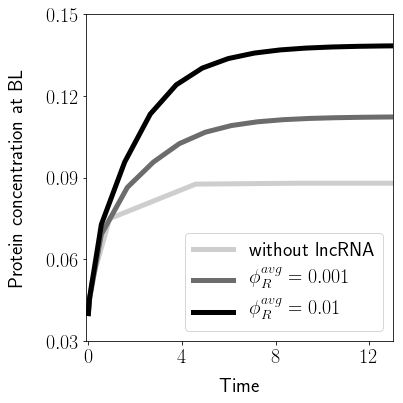

In [172]:
phi_p = [0.04]
diffusivity = 100.0
domain_radius = 15.0
tau_d = domain_radius**2/diffusivity

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                        '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/']
                         # '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                        # '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2$", "phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$", # "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$",    
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"] # "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$"]
labels = ['without lncRNA','$\phi^{avg}_R=0.001$', '$\phi^{avg}_R=0.01$'] # '$\phi^{avg}_R=0.002$', '$\phi^{avg}_R=0.005$']

variable_name = 'protein_in_SE'
ylabel = 'Protein concentration at BL'
cmap = 'Greys'

fig, axs = plt.subplots(1,1,figsize=(6,6))
color_vals = np.linspace(0.3,1.0,len(target_directory_list))


trajectories = get_list_of_trajectories(param_list=phi_p,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)
cmap = plt.get_cmap(cmap)
for i in range(len(target_directory_list)):
#     print(trajectories[i][phi_p[0]]['t']/tau_d)
#     print(trajectories[i][phi_p[0]][variable_name])
    axs.plot(trajectories[i][phi_p[0]]['t']/tau_d, trajectories[i][phi_p[0]][variable_name], 
                '-', c=cmap(color_vals[i]), label=labels[i],linewidth=5.0)

axs.set_ylabel(ylabel, labelpad=20)
axs.set_xlim([-0.1,13.0])
axs.set_ylim([0.03,0.15])
axs.xaxis.set_major_locator(MaxNLocator(4))
axs.yaxis.set_major_locator(MaxNLocator(4))

# axs.legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs.legend()

# axs.set_xlabel('Dimensionless time ($tD_P/R^2$)')
axs.set_xlabel('Time', labelpad=10)
plt.savefig('20220223 - Figures for paper/rna_localization_speeds_up_protein_recruitment_dynamics_protein_alone.svg', format='svg', dpi=600)

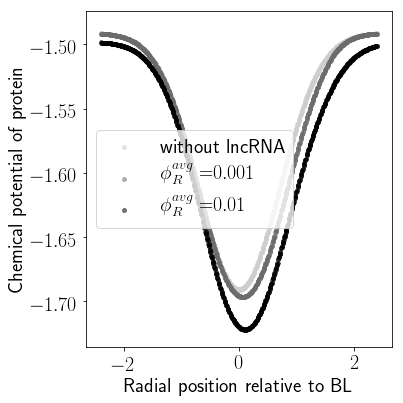

In [84]:
phi_r_list = [0.001, 0.01]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA'
name_pattern = "phi_p0_0.04_.*_phi_r_0{p}$"
mesh_d, data_d = get_chemical_potential(param_list=phi_r_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[4.0]*4, step_number=0)
c_max_list = [0.2]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX'
name_pattern = "phi_p0_0.04_.*_c_max_{p}$"
mesh_no_rna, data_no_rna =  get_chemical_potential(param_list=c_max_list, 
                                                    target_directory=target_directory, 
                                                    name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                                    L_P=[0.0], step_number=0)

L_P = 4.0
delta = 0.2
sigma = 5.0

cmap = plt.get_cmap('Greys')
color_vals = np.linspace(0.3,1.0,len(phi_r_list)+1)

fig,axs = plt.subplots(1,1,figsize=(6,6))
indices = [(mesh_no_rna.y < delta) * (mesh_no_rna.y > -delta) * (mesh_no_rna.x < 12.0) * (mesh_no_rna.x > -12.0)]
indices_with_SE_well = [(mesh_d.y < delta) * (mesh_d.y > -delta) * (mesh_d.x < 12.0-0.5*L_P) * (mesh_d.x > -12.0-0.5*L_P)]

axs.scatter((np.array(mesh_no_rna.x[indices]))/sigma,
                    np.array(data_no_rna[0.2]['mu_p'][indices]), label='without lncRNA', 
                    s=15, alpha=0.5, 
                    c=cmap(color_vals[0]))

for i in range(len(phi_r_list)):
    axs.scatter((np.array(mesh_d.x[indices_with_SE_well])+0.5*L_P)/sigma,
                    np.array(data_d[phi_r_list[i]]['mu_p'][indices_with_SE_well]), label=r'$\phi^{avg}_R=$'+'${}$'.format(str(phi_r_list[i])), 
                    s=15, alpha=0.5, 
                    c=cmap(color_vals[i+1]))
axs.legend()
axs.set_xlabel('Radial position relative to BL')
axs.set_ylabel('Chemical potential of protein')
plt.savefig('20220223 - Figures for paper/chemical_potential_profile_of_protein_at_t_0.svg', format='svg', dpi=600)

### When the RNA copy numbers are small, the speed up in protein recruitment for localized case is much higher compared to unlocalized case. This is due to the jumping effect

In [56]:
def get_time_constant(phi_profile, times):
    """
    Function to get the time at which the concentration in phi_profile reaches 90% of its maximum value
    Inputs:
    phi_profile, times
    """
    phi_max = np.max(phi_profile)
    phi_min = np.min(phi_profile)
    indices_near_steady_state = phi_profile > 0.9*(phi_max-phi_min) + phi_min
    times_near_steady_state = times[indices_near_steady_state]
    time_constant = times_near_steady_state.iloc[0]
    return time_constant

In [57]:
def get_initial_rate(phi_profile, times):
    """
    Function to get the initial rate of change of protein concentration
    Inputs:
    phi_profile, times
    """
    initial_rate = (phi_profile[1]-phi_profile[0])/(times[1]-times[0])
    return initial_rate

In [ ]:
# Acceleration in protein recruitment - ratio of time constants vs phi_r

phi_p = [0.04]

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/UNIFORM_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$",
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$",
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$",
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$",
                     "phi_p0_{p}_.*_c_max_0.2$"]
variable_name = 'protein_in_SE'  
labels = ["0.001","0.002","0.005","0.01"]
trajectories = get_list_of_trajectories(param_list=phi_p,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)

ratio = np.zeros(len(target_directory_list)/2)
for i in range(len(target_directory_list)/2):
    tau_u = get_time_constant(trajectories[2*i][phi_p[0]][variable_name], trajectories[2*i][phi_p[0]]['t'])
    tau_l = get_time_constant(trajectories[2*i+1][phi_p[0]][variable_name], trajectories[2*i+1][phi_p[0]]['t'])
    ratio[i] = tau_u/tau_l

fig, axs = plt.subplots(1,1,figsize=(4,5))
axs.bar(labels, ratio, color='grey', width=0.7)
axs.set_ylabel('$\uparrow$ in protein recruitment speed $\\tau_u/\\tau_l$')
axs.set_xlabel('RNA volume fraction $\phi^{avg}_R$')
axs.axhline(y=1.0, color='k', linestyle='--')
plt.savefig('20220223 - Figures for paper/rna_localization_speeds_up_protein_recruitment_time_constant.svg', format='svg', dpi=600)

In [ ]:
# Acceleration in protein recruitment - ratio of time constants vs phi_r

phi_p = [0.04]

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$",
                     "phi_p0_{p}_.*_c_max_0.2$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$",
                     "phi_p0_{p}_.*_c_max_0.2$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$",
                     "phi_p0_{p}_.*_c_max_0.2$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"]
variable_name = 'protein_in_SE'  
labels = ["0.001","0.002","0.005","0.01"]
trajectories = get_list_of_trajectories(param_list=phi_p,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)

ratio = np.zeros(len(target_directory_list)/2)
for i in range(len(target_directory_list)/2):
    rate_no_rna = get_initial_rate(trajectories[2*i][phi_p[0]][variable_name], trajectories[2*i][phi_p[0]]['t'])
    rate_with_rna= get_initial_rate(trajectories[2*i+1][phi_p[0]][variable_name], trajectories[2*i+1][phi_p[0]]['t'])
    ratio[i] = rate_with_rna/rate_no_rna

fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(labels, ratio, color='grey', width=0.7)
axs.set_ylabel('$\uparrow$ in protein recruitment rate to SE')
axs.set_xlabel('lncRNA concentration ($\phi^{avg}_R$)')
axs.axhline(y=1.0, color='k', linestyle='--')
axs.set_ylim([0.9,1.1])
plt.savefig('20220223 - Figures for paper/rna_localization_speeds_up_protein_recruitment_time_constant_relative_to_protein.svg', format='svg', dpi=600)

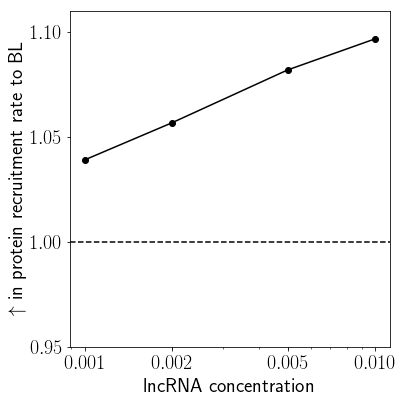

In [77]:
# Acceleration in protein recruitment - ratio of time constants vs phi_r

phi_p = [0.04]

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$",
                     "phi_p0_{p}_.*_c_max_0.2$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$",
                     "phi_p0_{p}_.*_c_max_0.2$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$",
                     "phi_p0_{p}_.*_c_max_0.2$", 
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$"]
variable_name = 'protein_in_SE'  
labels = [0.001, 0.002, 0.005, 0.01]
trajectories = get_list_of_trajectories(param_list=phi_p,
                                        target_directory_list=target_directory_list,
                                        name_pattern_list=name_pattern_list,
                                        variable_name=variable_name)

ratio = np.zeros(len(target_directory_list)/2)
for i in range(len(target_directory_list)/2):
    rate_no_rna = get_initial_rate(trajectories[2*i][phi_p[0]][variable_name], trajectories[2*i][phi_p[0]]['t'])
    rate_with_rna= get_initial_rate(trajectories[2*i+1][phi_p[0]][variable_name], trajectories[2*i+1][phi_p[0]]['t'])
    ratio[i] = rate_with_rna/rate_no_rna

fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.plot(labels, ratio, '-ko')
axs.set_ylabel('$\uparrow$ in protein recruitment rate to BL')
axs.set_xlabel('lncRNA concentration')

axs.axhline(y=1.0, color='k', linestyle='--')
axs.set_ylim([0.95,1.11])
axs.set_xscale('log')
axs.xaxis.set_ticks(labels)
axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs.yaxis.set_major_locator(MaxNLocator(4))
plt.savefig('20220223 - Figures for paper/rna_localization_speeds_up_protein_recruitment_time_constant_relative_to_protein.svg', format='svg', dpi=600)

In [ ]:
# Protein in SE due to localization

diffusivity = 100.0
domain_radius = 15.0
tau_d = domain_radius**2/diffusivity

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',                         
                         '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_VARY_PHIP0/LOCALIZED_LNCRNA/',
                         '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/']                    
name_pattern_list = ["phi_p0_{p}_.*_c_max_0.2_phi_r_00.001$",                     
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.002$",                     
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.005$",                     
                     "phi_p0_{p}_.*_c_max_0.2_phi_r_00.01$",
                     "phi_p0_{p}_.*_c_max_0.2$"]

variable_names = ['fold_protein_in_SE', 'rna_in_SE', 'rna_in_rna_locus']
ylabels = ['Protein enrichment at SE $\phi^{SE}_P/\phi^{avg}_P$',
           '$\phi_R$ at SE', '$\phi_R$ at RNA locus']
cmaps = ['Blues', 'Reds', 'Reds']
color_vals = np.linspace(0.3,1.0,len(target_directory_list))
labels = ["$\phi^{avg}_R$=0.0","$\phi^{avg}_R$=0.001","$\phi^{avg}_R$=0.002","$\phi^{avg}_R$=0.005","$\phi^{avg}_R$=0.01"]

N = len(variable_names)
fig, axs = plt.subplots(N,1,figsize=(5,6*N))

for j in range(len(variable_names)):
    trajectories = get_list_of_trajectories(param_list=phi_p,
                                            target_directory_list=target_directory_list,
                                            name_pattern_list=name_pattern_list,
                                            variable_name=variable_names[j])
    cmap = plt.get_cmap(cmaps[j])
    axs[j].plot(trajectories[-1][phi_p[0]]['t']/tau_d, trajectories[-1][phi_p[0]][variable_names[j]],
            '-', c=cmap(color_vals[0]), label=labels[0],linewidth=5.0)
    for i in range(len(target_directory_list)-1):
        axs[j].plot(trajectories[i][phi_p[0]]['t']/tau_d, trajectories[i][phi_p[0]][variable_names[j]],
            '-', c=cmap(color_vals[i+1]), label=labels[i+1],linewidth=5.0)
    axs[j].set_ylabel(ylabels[j])
    axs[j].set_xlim([-0.1,15.0])
    axs[j].legend(bbox_to_anchor=(1, 1), loc='left', ncol=1)
axs[j].set_xlabel('Dimensionless time $tD_P/R^2$')
plt.savefig('20220223 - Figures for paper/rna_localization_dynamical_trajectories.svg', format='svg', dpi=600)

Plots for ratio of time constants vs. phi_r

### Showing the RNA jumping effect

Plots for RNA concentration dynamics in both wells for different phi_r. Jumping happens only when concentrations are low. when the system is saturated with RNA, then nothing happens

This jumping effect at low RNA concentrations is also the reason for the distance dependence
Since lncRNA copy numbers are low and they are localized, we believe this is biologically important and that they can regulate condensate formation in a distance dependent manner.

Can illustrate this jumping effect and distance dependence through a plot of RNA concentration profiles for different distances and also a cartoon of two parabolas overlapping

The jumping effect essentially has two consequences:
1. Spatial dependence for how localized RNA helps protein recruitment (impact on eqbm protein recruitment)
2. Faster response in forming a condensate (impact on dynamics)

### Dynamics of protein and RNA concentrations at the different loci as a function of time

In [ ]:
### Generate dynamical trajectories

distance_list = [2.0, 6.0, 10.0]
phi_r_list = [0.001]

target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_EFFECT/'

for i in range(len(phi_r_list)):
    name_pattern = "phi_p0_0.04_.*_L_P_{p}_.*_c_max_0.2" + "_phi_r_0{phi_r}$".format(phi_r=phi_r_list[i])
    generate_dynamical_trajectories(param_list=distance_list,  
                                    target_directory=target_directory, 
                                    name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                    L_P=distance_list)

phi_p = 0.04
sigma = 5.0

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_EFFECT']
name_pattern_list = ["phi_p0_0.04_.*_L_P_{p}_.*_c_max_0.2" + "_phi_r_0{phi_r}$".format(phi_r=phi_r_list[i])
                     for i in range(len(phi_r_list))]

variable_name = 'protein_in_SE'
trajectory_phi_p_se = get_list_of_trajectories(param_list=distance_list,  
                                        target_directory_list=target_directory_list, 
                                        name_pattern_list=name_pattern_list,  
                                        variable_name=variable_name)
variable_name = 'rna_in_SE'
trajectory_phi_r_se = get_list_of_trajectories(param_list=distance_list,  
                                        target_directory_list=target_directory_list, 
                                        name_pattern_list=name_pattern_list,  
                                        variable_name=variable_name)
variable_name = 'rna_in_rna_locus'
trajectory_phi_r_rnalocus = get_list_of_trajectories(param_list=distance_list,  
                                        target_directory_list=target_directory_list, 
                                        name_pattern_list=name_pattern_list,  
                                        variable_name=variable_name)

In [ ]:
# Plot of phi_p_se vs phi_r_se for different distances

D_protein = 100
R = 15.0

fig, axs = plt.subplots(1, 1, figsize=(7,7))

for i in range(len(distance_list)):
    for j in range(len(phi_r_list)):
        y = trajectory_phi_p_se[j][distance_list[i]]['protein_in_SE']/phi_p
        x = trajectory_phi_r_se[j][distance_list[i]]['rna_in_SE']/phi_r_list[0]
        time = trajectory_phi_p_se[j][distance_list[i]]['t']*D_protein/R**2
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='coolwarm')
        # Set the values used for colormapping
        lc.set_array(time)
        lc.set_linewidth(5)
        line = axs.add_collection(lc)

fig.colorbar(line, ax=axs)
axs.set_ylabel('Protein concentration in SE ($\phi^{SE}_P/\phi^{avg}_P$)')
axs.set_xlabel('lncRNA concentration in SE ($\phi^{SE}_R/\phi^{avg}_R$)')
axs.set_ylim([0.9,3.0])
axs.set_xlim([0,9])
# axs.legend()
plt.savefig('20220223 - Figures for paper/phi_r_se_vs_phi_p_se_for_different_distances.svg', format='svg', dpi=600)

In [ ]:
# Plot of phi_r_se vs phi_r_lncRNA for different distances

fig, axs = plt.subplots(1, 1, figsize=(7,7))

for i in range(len(distance_list)):
    for j in range(len(phi_r_list)):
        y = trajectory_phi_r_rnalocus[j][distance_list[i]]['rna_in_rna_locus']/phi_r_list[0]
        x = trajectory_phi_r_se[j][distance_list[i]]['rna_in_SE']/phi_r_list[0]
        time = trajectory_phi_p_se[j][distance_list[i]]['t']*D_protein/R**2
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='coolwarm')
        # Set the values used for colormapping
        lc.set_array(time)
        lc.set_linewidth(5)
        line = axs.add_collection(lc)

fig.colorbar(line, ax=axs)
axs.set_ylabel('lncRNA concentration in lncRNA well ($\phi^{lw}_R/\phi^{avg}_R$)')
axs.set_xlabel('lncRNA concentration in SE ($\phi^{SE}_R/\phi^{avg}_R$)')
axs.set_ylim([4.5, 9.1])
axs.set_xlim([0, 9])
# axs.legend()
plt.savefig('20220223 - Figures for paper/phi_r_se_vs_phi_r_lncRNA_for_different_distances.svg', format='svg', dpi=600)

### Distance and amounts

In [147]:
### Generate dynamical trajectories


distance_list = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 15.0]
phi_r_list = [0.001, 0.002, 0.005, 0.01]

target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_PHIR0/'

for i in range(len(phi_r_list)):
    name_pattern = "phi_p0_0.04_.*_L_P_{p}_.*_c_max_0.2" + "_phi_r_0{phi_r}$".format(phi_r=phi_r_list[i])
    generate_dynamical_trajectories(param_list=distance_list,  
                                    target_directory=target_directory, 
                                    name_pattern=name_pattern, nx=300, dx=0.1, sigma=5.0, 
                                    L_P=distance_list)

Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_PHIR0/phi_p0_0.04_k_p_lncRNA_0.1_L_P_0.0_k_p_0.0_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_100.0_c_max_0.2_phi_r_00.001/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_PHIR0/phi_p0_0.04_k_p_lncRNA_0.1_L_P_2.0_k_p_0.0_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_100.0_c_max_0.2_phi_r_00.001/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_PHIR0/phi_p0_0.04_k_p_lncRNA_0.1_L_P_4.0_k_p_0.0_reactiontype_2.0_thresh_0.0_FE_8.0_MP_100.0_Mmrna_0.1_M_rna_100.0_c_max_0.2_phi_r_00.001/dynamical_trajectories.hdf5 ...
Succesfully wrote data to /nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_PHIR0/phi_p0_0.04_k_p_lncRNA_0.1_L_P_6.0_k

In [154]:
## Retrieve dynamical trajectory data

distance_list = [2.0, 4.0, 6.0, 8.0, 10.0, 15.0]
phi_r_list = [0.001, 0.002, 0.005, 0.01]
phi_p = 0.04
sigma = 5.0

target_directory_list = ['/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/MODIFIED_FH_DISTANCE_PHIR0/']*4
name_pattern_list = ["phi_p0_0.04_.*_L_P_{p}_.*_c_max_0.2" + "_phi_r_0{phi_r}$".format(phi_r=phi_r_list[i])
                     for i in range(len(phi_r_list))]

variable_name = 'fold_protein_in_SE'
trajectories = get_list_of_trajectories(param_list=distance_list,  
                                        target_directory_list=target_directory_list, 
                                        name_pattern_list=name_pattern_list,  
                                        variable_name=variable_name)

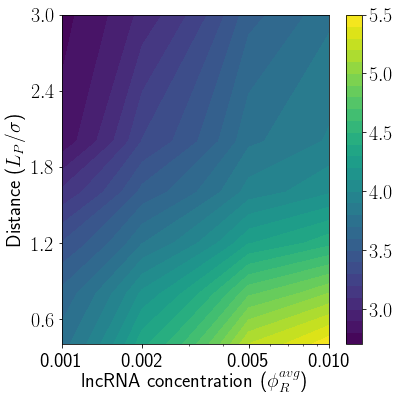

In [166]:
### Phase diagram for protein recruitment

protein_recruitment_to_enhancer = np.zeros([len(distance_list), len(phi_r_list)])
for i in range(len(distance_list)):
    for j in range(len(phi_r_list)):
        protein_recruitment_to_enhancer[i,j] = trajectories[j][distance_list[i]]['fold_protein_in_SE'][-1] 

L_P, phi_r = np.meshgrid(distance_list, phi_r_list)
fig,axs = plt.subplots(1,1,figsize=(6,6))

# contour = axs.contourf(L_P/sigma, phi_r, protein_recruitment_to_enhancer.transpose(), levels=30)
contour = axs.contourf(phi_r.transpose(), L_P.transpose()/sigma, protein_recruitment_to_enhancer, levels=30)
cbar = fig.colorbar(contour)
cbar.set_ticks(np.linspace(2.5,5.5,7))
cbar.set_clim()
axs.set_ylabel(r'Distance ($L_P/\sigma$)')
axs.set_xlabel(r'lncRNA concentration ($\phi^{avg}_R$)')
axs.set_xscale('log')
# axs.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.3f'))
axs.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
axs.yaxis.set_major_locator(MaxNLocator(5))
axs.xaxis.set_ticks(phi_r_list)
plt.savefig('20220223 - Figures for paper/protein_in_enhancer_at_equilibrium.svg', format='svg', dpi=600)
# axs.set_xlim([0.06,0.22])
# axs.set_ylim([0,0.25])

In [ ]:
### Phase diagram for speed of recruitment

diffusivity = 100.0
domain_radius = 15.0
tau_d = domain_radius**2/diffusivity

time_scale = np.zeros([len(distance_list), len(phi_r_list)])
for i in range(len(distance_list)):
    for j in range(len(phi_r_list)):
        time_scale[i,j] = get_time_constant(trajectories[j][distance_list[i]]['fold_protein_in_SE'],
                                            trajectories[j][distance_list[i]]['t'])

L_P, phi_r = np.meshgrid(distance_list, phi_r_list)
fig,axs = plt.subplots(1,1,figsize=(7,7))

contour = axs.contourf(L_P/sigma, phi_r, np.divide(tau_d, time_scale.transpose()), levels=30)
cbar = fig.colorbar(contour)
cbar.set_clim()
axs.set_xlabel(r'Distance $L_P/\sigma$')
axs.set_ylabel(r'Total RNA in system $\phi^{avg}_R$')
axs.set_yscale('log')
axs.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.3f'))
axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
plt.savefig('20220223 - Figures for paper/speed_of_protein_recruitment.svg', format='svg', dpi=600)
# axs.set_xlim([0.06,0.22])
# axs.set_ylim([0,0.25])